## GAN을 활용한 MNIST dataset 학습

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
n_output = 784 # 28×28 이미지 크기
n_noise = 128 # 랜덤 노이즈 벡터 크기

# 학습 관련 변수 설정
n_epoch = 100 # 에폭 수
batch_size = 128 # 미니 배치 크기
saving_interval = 10 # 결과 이미지 저장을 위한 간격

# MNIST 데이터 불러오기 및 정규화
(train_images, _), (_, _) = mnist.load_data()
buffer_size = len(train_images) # 훈련 이미지 개수 추출 : 60,000개
train_images = train_images.reshape((buffer_size, n_output)) # 28x28
# 이미지 픽셀값을 [–1~1]로 정규화
train_images = (train_images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)


In [5]:
# 생성자 모델 정의, 128차원의 랜덤 노이즈 벡터를 입력받아서 784차원의 벡터(28×28)이미지를 출력
generator = Sequential()
generator.add(Dense(units=256 , input_dim=n_noise, activation='relu'))
generator.add(Dense(units=512, activation='relu'))
generator.add(Dense(units=n_output, activation='tanh'))

# 판별자 모델 정의
discriminator = Sequential()
discriminator.add(Dense(256, input_dim=n_output, activation='relu'))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))

In [6]:
# 생성자와 판별자 모델을 통합한 GAN 모델 구현
g_input = Input(shape=(n_noise,))
g_output = discriminator(generator(g_input))
gan = Model(g_input, g_output)

discriminator.trainable = True
adam = tf.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# GAN 모델 학습을 위한 최적화 함수 및 손실 함수 설정
# GAN 모델에 대한 학습은 오직 생성자에 대한 가중치 업데이트가 수행되어야 하므로 판별자 모델의 학습 여부를 False로 설정함
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=adam)
# GAN 모델 구조 출력
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               566800    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 201217    
                                                                 
Total params: 768,017
Trainable params: 566,800
Non-trainable params: 201,217
_________________________________________________________________


Epoch Num : 1/100
3/3 [==============================] - 0s 6ms/step
Epoch:1 d_loss:0.5972  g_loss:0.8324
1/1 [==============================] - 0s 30ms/step


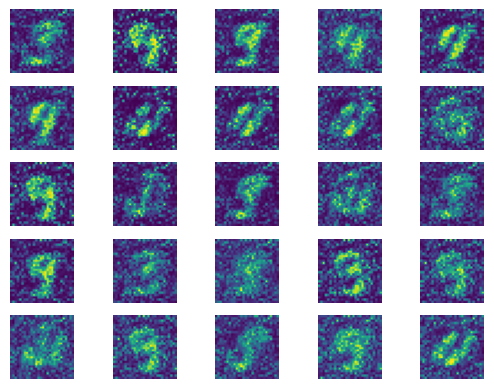

Epoch Num : 2/100
3/3 [==============================] - 0s 5ms/step
Epoch Num : 3/100
4/4 [==============================] - 0s 5ms/step


In [ ]:
# 1) 모델 오차 계산 및 가중치 갱신
# 2) 중간 과정 생성 이미지 확인
for i in range(n_epoch):
  print('Epoch Num : {}/{}'.format((i + 1), n_epoch))

  # 1) 미니-배치별 모델 가중치 갱신 및 오차 계산
  for image_batch in train_dataset: # 미니-배치별 가중치 갱신
    # 현재 배치 크기만큼 진짜 및 가짜 레이블 배열 생성
    n_bt_imgs = len(image_batch) # 현재 반복에서의 배치 이미지 개수 추출
    true_labels = np.ones((n_bt_imgs, 1)) # 진짜 레이블(1) 생성
    fake_labels = np.zeros((n_bt_imgs, 1)) # 가짜 레이블(0) 생성

    # 1) 미니-배치별 모델 가중치 갱신 및 오차 계산
    # 현재 배치에 대한 판별자 모델의 1회 가중치 갱신 및 오차 계산
    # 1)진짜 이미지들에 대한 판별자 모델 가중치 갱신 및 오차 계산
    d_loss_real = discriminator.train_on_batch(image_batch, true_labels)
    # 2) 가짜 이미지들에 대한 판별자 모델 가중치 갱신 및 오차 계산
    noise = np.random.normal(0, 1, (n_bt_imgs, n_noise))
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake_labels)
    # 판별자 모델의 최종 오차 : d_loss_real과 d_loss_fake의 평균값으로 사용
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    # GAN 모델에 대한 학습은 오직 생성자에 대한 가중치 업데이트가 수행
    # 현재 배치에 대한 GAN 모델 1회 가중치 갱신 및 오차 계산=>Generator만 학습
    g_loss = gan.train_on_batch(noise, true_labels) 

# 2) 중간 과정 생성 이미지 확인
  if (i + 1) % saving_interval == 0 or i == 0:
    print('Epoch:%d' % (i + 1), 'd_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)
    # 학습된 생성자 모델을 이용하여 25개의 이미지 생성
    noise = np.random.normal(0, 1, (25, n_noise)) # 25개의 노이즈 벡터 생성
    gen_imgs = generator.predict(noise) # 생성자를 이용한 25개의 이미지 생성
    # 이미지 픽셀값 0~1로 조정
    gen_imgs = 0.5 * gen_imgs + 0.5 
    fig, axs = plt.subplots(5, 5)
    count = 0
    for j in range(5):
      for k in range(5):
        axs[j, k].imshow(np.reshape(gen_imgs[count], (28, 28)))
        axs[j, k].axis('off')
        count += 1
    plt.show()
    fig.savefig("/content/drive/MyDrive/pop/mnist&cifal-dataset/gan_result/g_mnist_%d.png" % (i + 1)) #경로가 지정되어 있지 않다면 이 부분을 막고 실행


## Functional API를 이용한 모델 구현

In [ ]:
# 생성자 모델 정의
# 128차원의 랜덤 노이즈 벡터를 입력받아서 784차원의 벡터(28×28)이미지를 출력
generator = Sequential()
generator.add(Dense(units=256, input_dim=n_noise, activation='relu'))
generator.add(Dense(units=512, activation='relu'))
# tanh 활성화 함수 사용하여 -1~1사이로 픽셀값 통일
generator.add(Dense(units=n_output, activation='tanh'))

# 판별자 모델 정의
# 이미지(28×28=784)를 입력받아, 진짜인지 가짜인지 판단
discriminator = Sequential()
discriminator.add(Dense(256, input_dim=n_output, activation='relu'))
discriminator.add(Dropout(0.3))
# sigmoid 활성화 함수 사용하여 0~1 사이 출력값 가짐
discriminator.add(Dense(1, activation='sigmoid'))

In [ ]:

#MNIST 데이터셋을 로드하여 준비. 샘플 값을 정수에서 부동소수로 변환
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
# 28x28차원의 벡터가 60000개 채널은 1개
train_images = train_images.reshape((60000, 28*28,1))
test_images = test_images.reshape((10000, 28*28,1))
train_images, test_images = train_images / 255.0, test_images / 255.0
one_hot_train_labels = to_categorical(train_labels, 10)
one_hot_test_labels = to_categorical(test_labels, 10)

# Functional API를 이용한 모델 구현
# tensorflow.keras.models.Model의 inputs() & outputs() 메소드 설정을 이용해 모델 정의
inputs = tf.keras.Input(shape=(28*28, ))
x=Dense(input_dim=784,units=256,activation='relu')(inputs)
y=Dense(input_dim=784,units=256,activation='relu')(inputs)
C=x+y
outputs=Dense(input_dim=256,units=10,activation='sigmoid')(C)
model=Model(inputs=inputs,outputs=outputs)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
history = model.fit(train_images, one_hot_train_labels, epochs=5, batch_size=10)
print("\n=============test results==========")
labels=model.predict(test_images)
print("\n Accuracy: %.4f" % (model.evaluate(test_images, one_hot_test_labels, verbose=2)[1])) #list index

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 256)          200960      ['input_1[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 256)          200960      ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 256)         0           ['dense_5[0][0]',                
 da)                                                              'dense_6[0][0]']            